## Imports

In [5]:
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, EarlyStopping, LRScheduler

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt

import numpy as np

import os
import sys

sys.path.append(os.path.abspath('..'))

from src.models.TurbulenceNetwork import TurbulenceNetwork
from src.models.Ensembles import DeepEnsemble
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *
from src.utils.loss_metric_utils import DiagNLLLoss, MAPELoss, RMSELoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

%load_ext autoreload
%autoreload 2


Device:  cuda:0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

Out noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


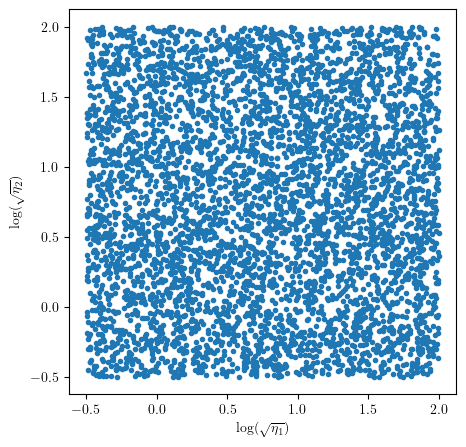

In [6]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = True
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = np.array([-0.5, 0.0])
eta_2_range = np.array([-.5, 0.0])

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type='out_noise', d_condition="<=", noise=0.0001)

etas_test, gs_test = generate_log_data(SSG_gen, log, 10_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)


In [7]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32)

## Network Training

In [12]:
# Defining model parameters
chkpt_prefix = 'D_GT_0_20k'
chkpt_dir = '../Model_Checkpoints/Ensemble/20k/' + chkpt_prefix + '/'


net_params = {
    "input_dim": 2,
    "output_dim": 3,
    "num_layers": 4,
    "h_dim": 20,
    "out_noise": False
}

train_params = {
    "criterion": DiagNLLLoss,  # RMSELoss, MAPELoss, DiagNLLLoss
    "optimizer": torch.optim.Adam,
    "optimizer__weight_decay": 1e-6,
    "lr": 0.001,
    "batch_size": 64,
    "max_epochs": 500,
    "device": device,
    "iterator_train__shuffle": True,
    "iterator_train__num_workers": 4,
    "iterator_train__pin_memory": True,
    "iterator_valid__shuffle": False,
    "iterator_valid__num_workers": 4,
    "iterator_valid__pin_memory": True,
    "verbose": 0,
}

def create_ensemble_mem(i):
    net_name = chkpt_prefix + f'_Ens_{i}.pt'

    callbacks = [EarlyStopping(patience=15, threshold=0.001, threshold_mode='abs', monitor='valid_loss', lower_is_better=True),
            Checkpoint(monitor='valid_loss_best', f_params=net_name, dirname=chkpt_dir),
            LRScheduler(policy=ReduceLROnPlateau, monitor='valid_loss', factor=0.5, patience=5, threshold=0.00001, threshold_mode='abs', mode='min')
        ]
    train_params['callbacks'] = callbacks

    return create_skorch_model(TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)

num_members = 40

In [59]:
DE = DeepEnsemble(create_ensemble_mem, num_members)

DE = DE.fit(x_train, y_train)

/home/codygrogan/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Predictor 1 trained
Predictor 2 trained
Predictor 3 trained
Predictor 4 trained
Predictor 5 trained
Predictor 6 trained
Predictor 7 trained
Predictor 8 trained
Predictor 9 trained
Predictor 10 trained
Predictor 11 trained
Predictor 12 trained
Predictor 13 trained
Predictor 14 trained
Predictor 15 trained
Predictor 16 trained
Predictor 17 trained
Predictor 18 trained
Predictor 19 trained
Predictor 20 trained
Predictor 21 trained
Predictor 22 trained
Predictor 23 trained
Predictor 24 trained
Predictor 25 trained
Predictor 26 trained
Predictor 27 trained
Predictor 28 trained
Predictor 29 trained
Predictor 30 trained
Predictor 31 trained
Predictor 32 trained
Predictor 33 trained
Predictor 34 trained
Predictor 35 trained
Predictor 36 trained
Predictor 37 trained
Predictor 38 trained
Predictor 39 trained
Predictor 40 trained


## Reloading Ensemble

In [15]:
chkpt_prefix = 'D_GT_0_20k'
chkpt_dir = '../Model_Checkpoints/Ensemble/20k/' + chkpt_prefix + '/'

DE = DeepEnsemble(create_ensemble_mem, num_members)
DE = DE.load(reinitialize_model, lambda i: chkpt_dir + chkpt_prefix + f'_Ens_{i}.pt')

40 Predictor(s) loaded


## Generating Statistics Data

0.051435301854909736


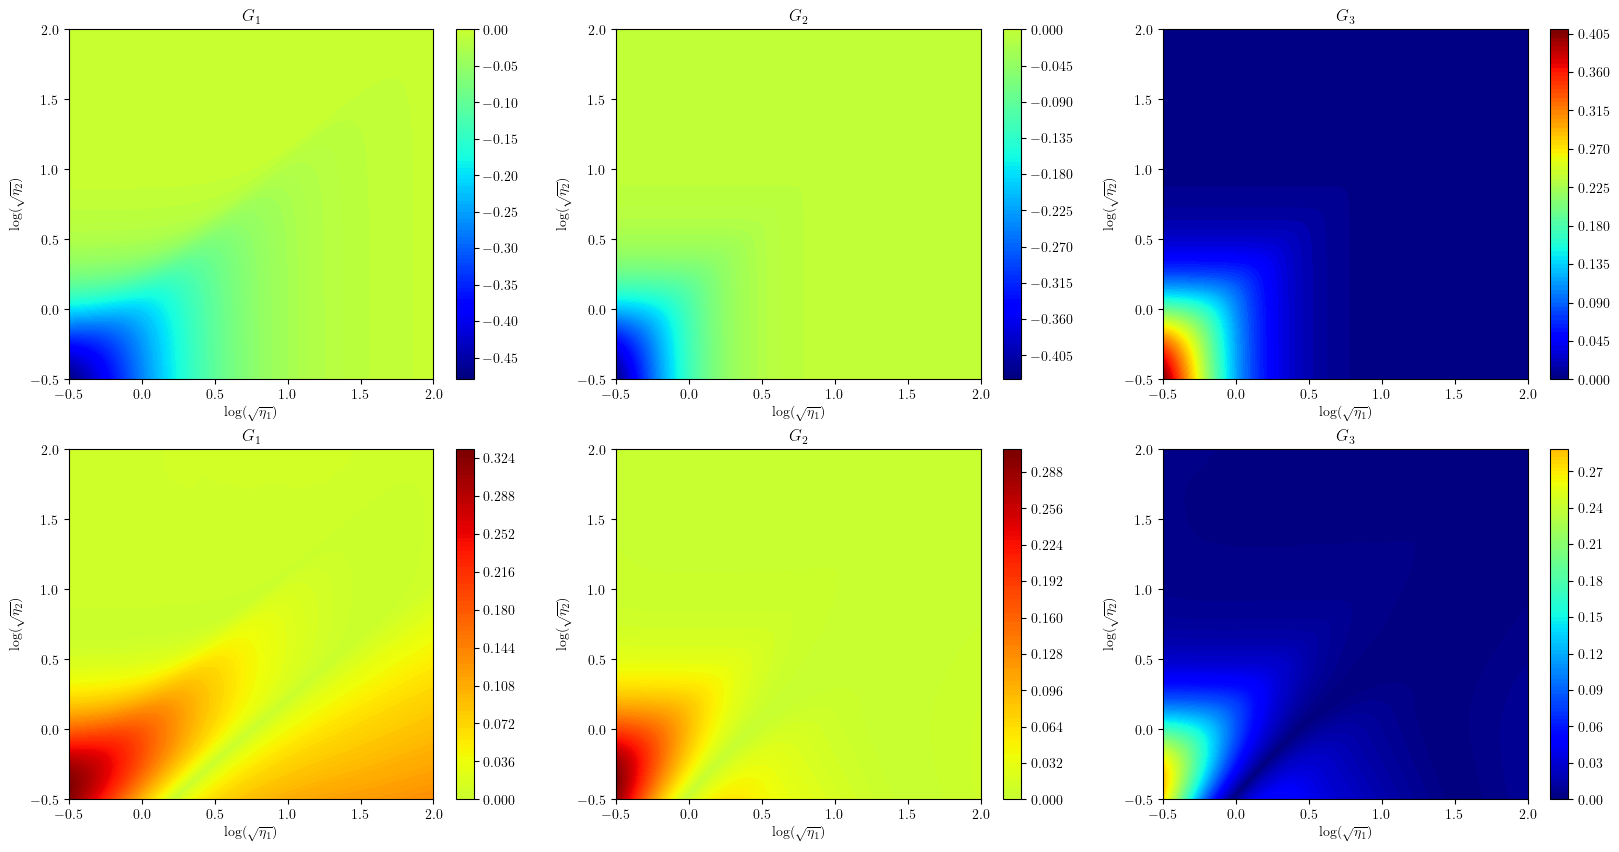

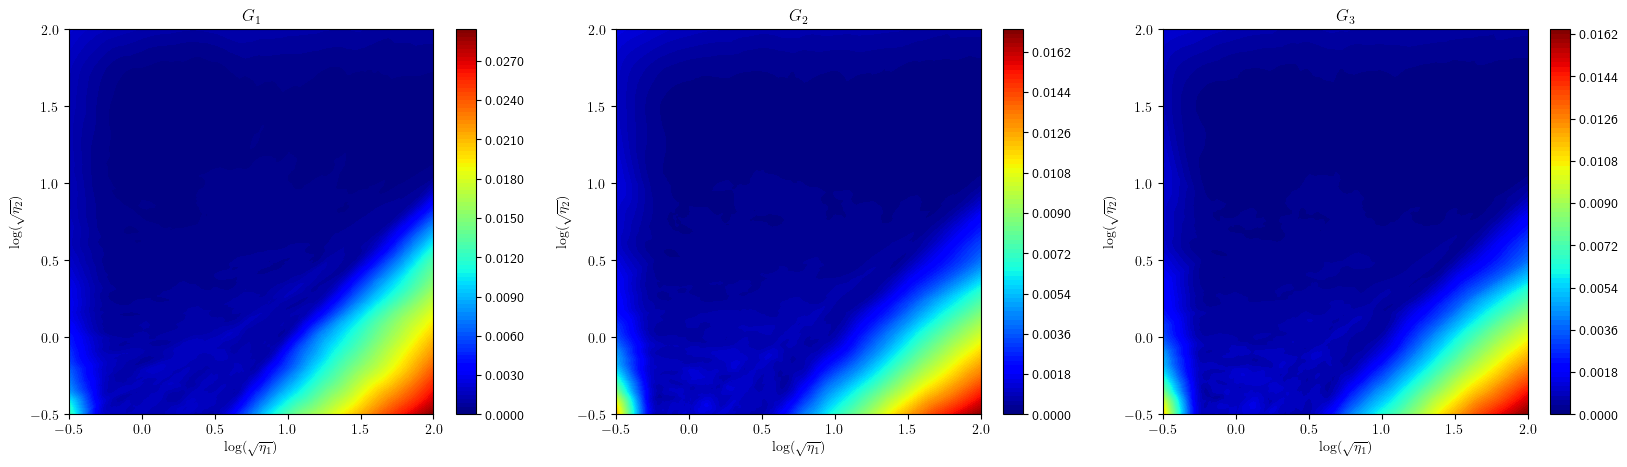

In [14]:
test_criteria = RMSELoss()
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s.T.reshape(3, dim, dim)

etas = x_scaler.transform(etas)

preds = np.zeros((num_members, len(etas), 3))
stds = np.zeros((num_members, 3))
for i in range(DE.n_predictors):
    pred = DE.predictors[i].predict(etas.astype(np.float32))
    preds[i] = y_scaler.inverse_transform(pred)
    if 'out_noise' in net_params and net_params['out_noise']:
        stds[i] = DE.predictors[i].module_.sigma.detach().cpu().numpy()


#pred_test = np.tensordot(weights.reshape(1,-1), preds, axes=(1, 0)).squeeze()
pred = preds.mean(axis=0)

std = preds.std(axis=0)


if 'out_noise' in net_params and net_params['out_noise']:
    alea_std = stds.mean(axis=0) * y_scaler.scale_  # scale the std by the scaler's scale
    print("Ensemble noise std: ", alea_std)
    std = np.sqrt(std**2 + alea_std**2)
    np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Sigmas.csv', alea_std, delimiter=',')

np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Mean.csv', pred, delimiter=',')
np.savetxt('../data/Ensemble/' + chkpt_prefix + '_Pred_Std.csv', std, delimiter=',')

#rmse_test = test_criteria(torch.tensor(target), torch.tensor(pred_test).T.reshape(3, dim, dim)).item()

rmse = test_criteria(torch.tensor(target), torch.tensor(pred).T.reshape(3, dim, dim)).item()

#print(rmse_test)
print(rmse)

plot_heat_map_compare(x_grid, y_grid, target, np.abs(target - pred.T.reshape(3, dim, dim)), 'Algebraic', 'Ensemble', sup_title=False)

plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim), "Ensemble Standard Deviation", sup_title=False)

## Reload Runs

0.02232117474062385


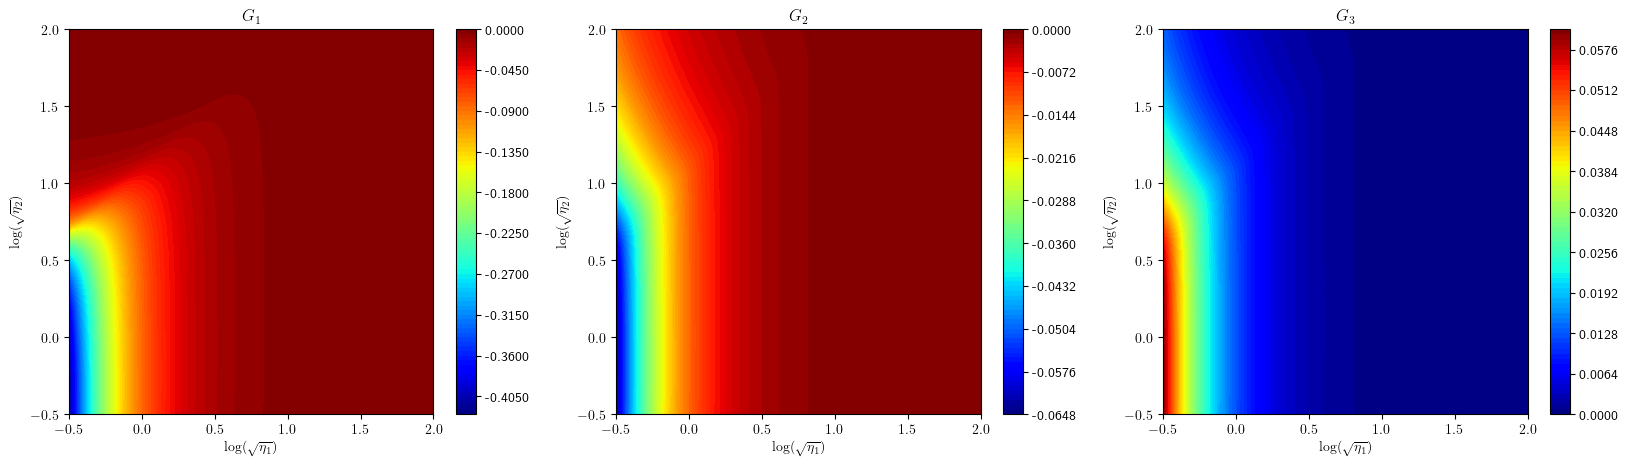

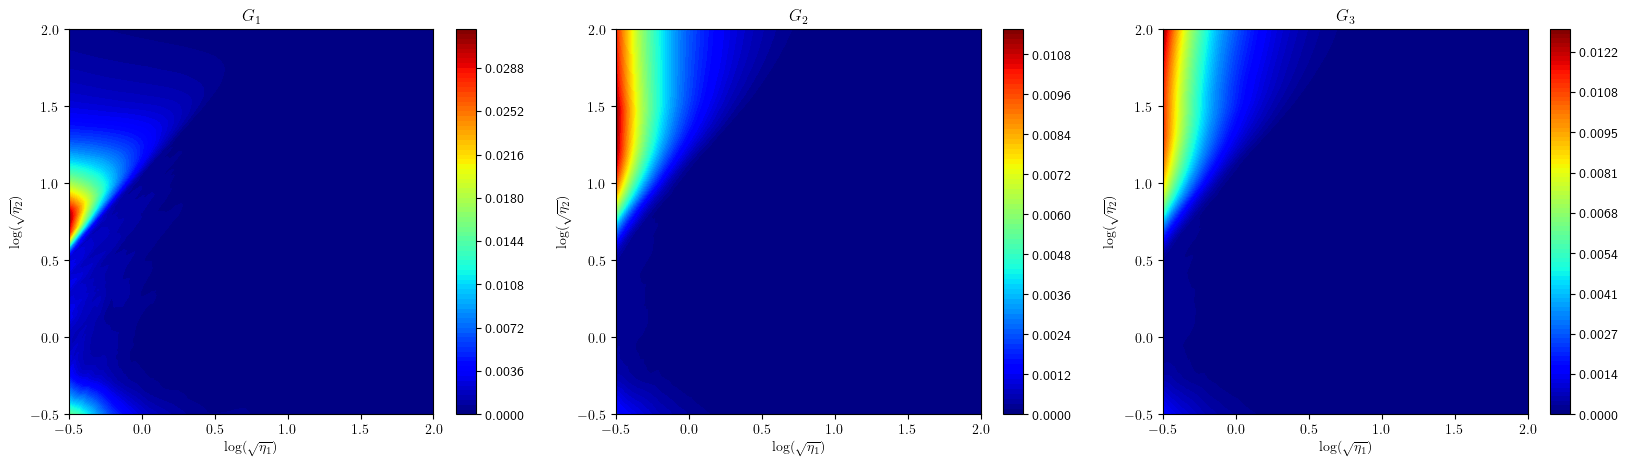

In [26]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)

pred = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Mean.csv', delimiter=',')
std = np.loadtxt('../data/Ensemble/D_LT_0_Pred_Std.csv', delimiter=',')

print(np.mean(np.abs(G_s - pred)))

plot_heat_map_3D(x_grid, y_grid, pred.T.reshape(3, dim, dim))
plot_heat_map_3D(x_grid, y_grid, std.T.reshape(3, dim, dim))

## Visualizing Functions

In [17]:
predictions = []
for member in ensemble:
    predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

predictions.append(y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1))

vis_outputs = np.concatenate(predictions, axis=0)

Calculating PHATE...
  Running PHATE on 21 observations and 2400 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.01 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.02 seconds.
  Calculating optimal t...
    Automatically selected t = 10
  Calculating diffusion potential...
  Calculating metric MDS...
Calculated PHATE in 0.02 seconds.


/home/codygrogan/.local/lib/python3.12/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (21, 2400) is expensive. Consider setting n_pca.
  warnings.warn(


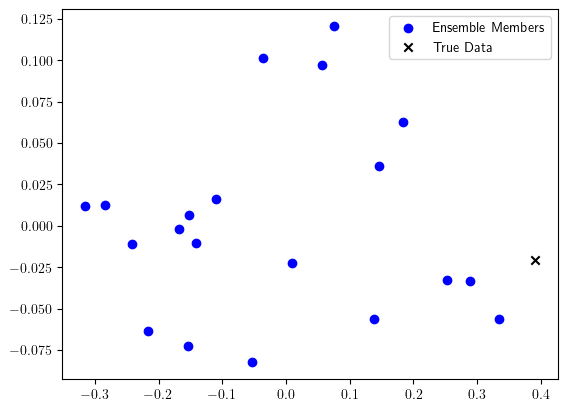

In [19]:
from phate import PHATE

phate = PHATE(n_components=2, n_jobs=4)

embedding = phate.fit_transform(vis_outputs)

plt.scatter(embedding[:-1, 0], embedding[:-1, 1], c='b', label='Ensemble Members')

plt.scatter(embedding[-1, 0], embedding[-1, 1], c='black', marker='x', label='True Data')

plt.legend()
plt.show()